<a href="https://colab.research.google.com/github/hws2002/Deep_Learning_with_Keras/blob/main/Chapter10/Chapter10_2_temperature_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2025-01-12 00:51:25--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.0.20, 52.217.168.248, 3.5.22.136, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.0.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.1MB/s    in 0.7s    

2025-01-12 00:51:26 (18.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


데이터를 살펴보자

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

In [8]:
lines = data.split("\n")
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


42만 551개의 데이터 전체를 넘파이 배열로 바꾸자.  
온도를 하나의 배열로 만들고 나머지 데이터를 또 다른 배열로 만들어서, 두 번째 배열이 미래 온도를 예측하기 위해 사용할 특성으로 사용하자.(Date Time 열은 제외시킬것임)

In [9]:
lines[3]

'01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00'

In [24]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in lines[i].split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values

시간에 따른 온도 그래프를 시각화해보자

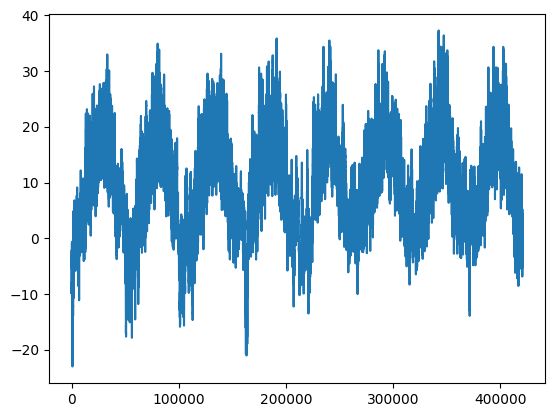

In [30]:
import matplotlib.pyplot as plt

plt.plot(temperature)
plt.show()

기간을 좁혀서 처음 10일간의 온도 데이터를 나타내보자

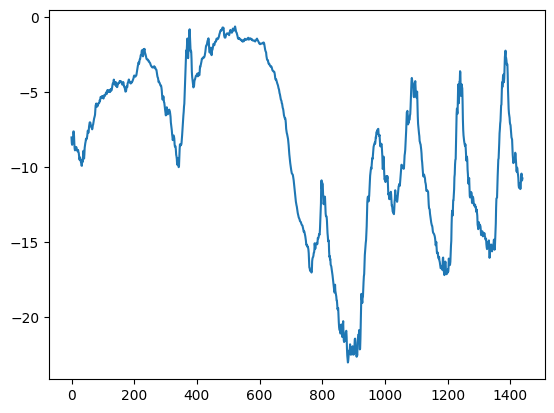

In [31]:
plt.plot(temperature[:1440])
plt.show()

이 그래프에서 일별 주기성을 볼 수 있다.

## 예측
주기성이 있으므로, 지난 몇 달 간의 데이터를 사용하여 다음 달의 평균 온도를 예측하는 문제는 쉬운 편임. 하지만 하루하루 데이터를 살펴보면 온도 변화가 매우 불안정하므로, 일자별 수준의 시계열 데이터를 예측하기란 쉽지 않음.  

처음 50%의 데이터를 훈련에 사용하고 다음 25%를 검증, 마지막 25%를 테스트에 사용해 보자.

In [32]:
num_train_samples = int(.5 * len(raw_data))
num_val_samples = int(.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [33]:
print("num_train_samples : ", num_train_samples)
print("num_val_samples : ", num_val_samples)
print("num_test_samples : ", num_test_samples)

num_train_samples :  210225
num_val_samples :  105112
num_test_samples :  105114


## 데이터 준비
한 시간에 한 번씩 샘플링된 5일간의 데이터가 주어졌을 때, 24시간 뒤의 온도를 예측해 보는 모델을 만들어 보자  

먼저 데이터를 신경망에 주입할 수 있는 형태로 전처리 해야 함.  
이 작업은 쉬움. 데이터가 이미 수치형이기 때문에 어떤 벡터화도 필요하지 않음.  
하지만 이 데이터에 있는 시계열은 스케일이 각기 다르기 때문에, 시계열을 독립적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸어 보자.  

In [34]:
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

이제 과거 5일치 데이터와 24시간 뒤 타깃 온도의 배치를 반환하는 Dataset 객체를 만들어 보자.  
이 데이터셋에 있는 샘플은 중복이 많아서(샘플 N과 샘플 N+1은 대부분의 타임스텝이 중복되어 있음)  
모든 샘플을 메모리에 적재하면 낭비가 심하므로, 그 대신 raw_data와 temperature 배열만 메모리에 유지하고 그때그때 샘플을 생성해보자.  

파이썬 제너레이터를 만들어 처리할 수 있지만 케라스에 내장된 데이터셋 유틸리티(timeseries_dataset_from_array()) 를 사용해 보자.


다음과 같은 매개변수 값을 사용해보자
* sampling_rate = 6 : 원본데이터는 10분마다 측정되었으므로, 시간당 하나의 데이터 포인트를 샘플링하기 위해 6개의 데이터 포인트중 하나만 사용하자
* sequence_length = 120 : 이전 5일간(120시간) 데이터를 사용하자
* delay = sampling_rate * (sequence_length + 24 - 1) : 시퀀스의 타깃은 시퀀스 끝에서 24시간 후의 온도임

훈련 데이터셋을 만들 떄 처음 50%의 데이터만 사용하기 위해 start_index = 0 과 end_index = num_train_samples로 지정함.  

검증 데이터셋의 경우 그다음 25%를 사용하기 위해 start_index = num_train_samples와 end_index = num_train_samples + num_val_samples로 지정함.  
마지막 테스트 데이터셋의 경우 남은 샘플을 사용하기 위해 start_index = num_train_samples + num_val_samples로 지정함

In [67]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

In [68]:
val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

In [69]:
test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

각 데이터셋은 (samples, targets)크기의 튜플을 반환함. samples는 256개(batch_size)의 샘플로 이루어진 배치임.  
각 샘플은 연속된 120시간의 입력 데이터를 담고 있음.
샘플이 랜덤하게 섞여 있기 때문에 배치에 있는 연속된 두 샘플이 꼭 시간적으로 가까운 것은 아님

# 베이스라인 모델
24시간 후 온도가 지금과 동일하다고 예측하는 모델을 베이스라인으로 잡고, 평균 절댓값 오차(MAE)로 평가해 보가

In [70]:
def evaluate_naive_method(datset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in datset:
    preds = samples[:,-1,1] * std[1] + mean[1] # 특성을 정규화했기 때문에 온도를 섭씨로 바꾸려면 표준 편차를 곱하고
    # 평균을 더해야 함
    total_abs_err += np.sum(np.abs(targets - preds))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"검증 MAE : {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE : {evaluate_naive_method(test_dataset):.2f}")

검증 MAE : 2.44
테스트 MAE : 2.62


베이스라인 모델은 검증 MAE와 테스트 MAE에서 각각 2.52도와 2.71도를 달성했음. 따라서 24시간 후의 온도를 항상 현재와 같다고 예측하면 평균적으로 2.6도 정도 차이가 날 것임. 아주 나쁘지는 않지만 이런 규칙을 기반으로 날씨 예보 서비스를 시작하지는않을 것임 이제 딥러닝 모델이 더 나은지 시도해 보자.

# 기본적인 머신 러닝 모델 시도해 보기

RNN모델을 만들기 전에, 먼저 간단하고 손쉽게 만들 수 있는 머신 러닝 모델을 만들어 보자.  

데이터를 펼쳐서 2개의 Dense층을 통과시키는 완전 연결 네트워크를 만들어 보자. 회귀 문제이므로 마지막 Dense층에 활성화 함수를 두지 않을 것이고, 경사 하강법을 적용하기 위해 MAE대신 MSE를 사용해 보자.( 단,  모니터링할 지표로 MAE를 추가하자)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = "relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only = True)
]

model.compile(
    optimizer = "rmsprop",
    loss = "mse" ,
    metrics = ['mae']
)

history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = callbacks)

In [ ]:
model= keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

훈련과 검증 손실 곡선을 그려 보자

In [ ]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, 'b', label = "Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 1D 합성곱 모델 시도해 보기

In [81]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = "relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation = "relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = "mse", metrics = ['mae'])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 97, 8)               │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 18, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 13, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - loss: 30.8236 - mae: 4.2917 - val_loss: 16.4790 - val_mae: 3.2081
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 17.6111 - mae: 3.2864 - val_loss: 15.1719 - val_mae: 3.0928
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 14.2468 - mae: 2.9856 - val_loss: 14.4944 - val_mae: 2.9960
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - loss: 13.3573 - mae: 2.8943 - val_loss: 14.4013 - val_mae: 2.9981
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 12.6514 - mae: 2.8098 - val_loss: 15.5773 - val_mae: 3.0983
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - loss: 12.1645 - mae: 2.7559 - val_loss: 14.9472 - val_mae: 3.0444
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - loss: 11.7081 - mae: 2.7039 - val_loss: 14.5450 - val_mae: 2.9944
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - loss: 11.2976 - mae: 2.6559 - val_loss: 17.3226 - val_mae: 3.2802
Epoch 9/10
819/819 ━━━━━

In [83]:
model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 15.9151 - mae: 3.1655
테스트 MAE : 3.17


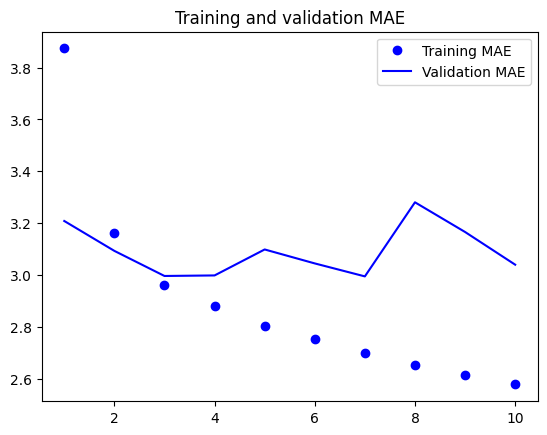

In [84]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, 'b', label = "Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

이 모델은 밀집 연결 모델보다 더 성능이 나쁨.  
무엇이 문제일까? 두 가지가 있다.  
1. 첫째, 날씨 데이터는 평행 이동 불변성 가정을 많이 따르지 않음. 데이터에 일별 주기성이 있지만, 아침 데이터는 저녁이나 한밤중의 데이터와 성질이 다름. 날씨 데이터는 매우 특정한 시간 범위에 대해서만 평행 이동 불변성을 가짐

2. 둘째, 이 데이터는 순서가 많이 중요함. 최근 데이터가 5일 전 데이터보다 내일 온도를 예측하는데 훨씬 더 유용함. 하지만 1D 컨브넷은 이런 사실을 활용할 수 없음. 특히 최대 풀링과 전역 평균 풀링 층 대문에 순서 정보가 많이 삭제됨.

# 순환 신경망
합성곱 모델은 데이터의 모든 부분을 비슷한 방식으로 처리했으며 풀링을 적용하여 순서 정보를 잃어버림. 이런 방법 대신에 인과 관계와 순서가 의미 있는 시퀀스 데이터를 그대로 사용해 보자.  

이런 문제를 위해 특별히 고안된 신경망 구조가 순환 신경망임.  
그중에서도 LSTM층이 오랫동안 인기가 많았음. 일단 LSTM층을 작동시켜 보자

In [ ]:
inputs - keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = "mse", metrics = ['mae'])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)


In [87]:
model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 11.0089 - mae: 2.5882
테스트 MAE : 2.59


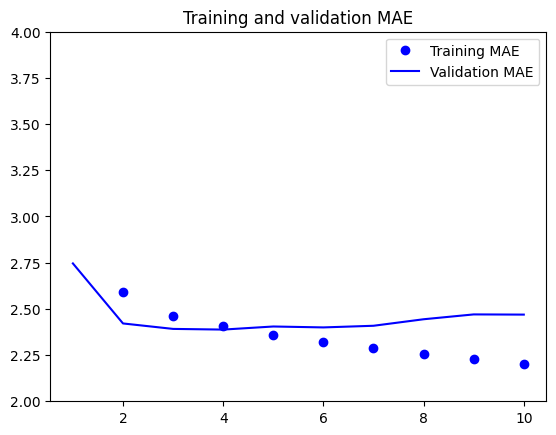

In [96]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, 'b', label = "Validation MAE")
plt.title("Training and validation MAE")
plt.ylim(2.0, 4.0)
plt.legend()
plt.show()